# 2023.05.17 RNN
Dataset Info.

train [폴더]

    학습을 위한 소리 샘플
    TRAIN_0000.wav ~ TRAIN_5000.wav


test [폴더]

    추론을 위한 소리 샘플
    TEST_0000.wav ~ TEST_1880.wav


train.csv [파일]

    id : 샘플 별 고유 ID
    path : 음향 샘플 파일 경로
    label : 감정의 종류
    0: angry
    1: fear
    2: sad
    3: disgust
    4: neutral
    5: happy


test.csv [파일]

    id : 샘플 별 고유 ID
    path : 음향 샘플 파일 경로


sample_submission.csv [파일] - 제출 양식

    id : 샘플 별 고유 ID
    label : 예측한 감정의 종류


This Crowd-sourced Emotional Mutimodal Actors Dataset (CREMA-D) is made available under the Open Database License: 

http://opendatacommons.org/licenses/odbl/1.0/. 

Any rights in individual contents of the database are licensed under the Database Contents License: 

http://opendatacommons.org/licenses/dbcl/1.0/



In [1]:
file_dir = '데이콘 음성 감정 인식'

In [2]:
import pandas as pd

train_df = pd.read_csv(file_dir + '/train.csv')
test_df = pd.read_csv(file_dir + '/test.csv')

In [3]:
train_df['path'] = [i.replace('./train', file_dir+'/train') for i in train_df['path']]

In [4]:
test_df['path'] = [i.replace('./test', file_dir+'/test') for i in test_df['path']]

In [5]:
#!pip install librosa --user librosa깔 때는 꼭 이거쓰기!!

In [6]:
import numpy as np
import pandas as pd
import os
import librosa
#import librosa.display <<이새끼가 matplotlib이랑 충돌 남
import IPython
from IPython.display import Audio
from IPython.display import Image
import matplotlib.pyplot as plt

EMOTIONS = { 0: 'angry'
			,1: 'fear'
			,2: 'sad'
			,3: 'disgust'
			,4: 'neutral'
			,5: 'happy'}
SAMPLE_RATE = 48000

In [7]:
print("number of files is {}".format(len(train_df)))

number of files is 5001


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5001 entries, 0 to 5000
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5001 non-null   object
 1   path    5001 non-null   object
 2   label   5001 non-null   int64 
dtypes: int64(1), object(2)
memory usage: 117.3+ KB


In [9]:
EMOTIONS[0]

'angry'

In [10]:
def relabel(x):
    return EMOTIONS[x]

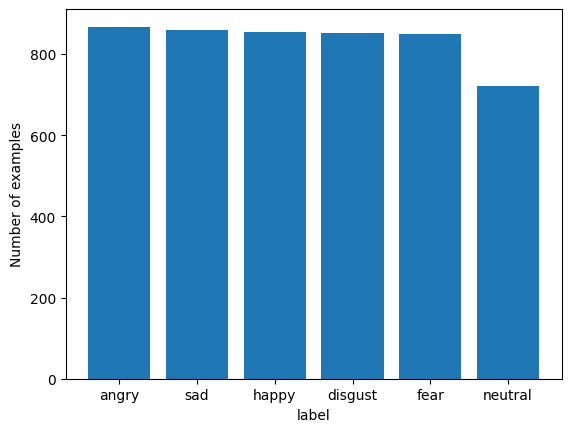

In [11]:
#%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
ax = fig.add_subplot(111)
counts = train_df['label'].value_counts()
ax.bar(x=[relabel(i) for i in list(counts.index)], height=counts.values)
ax.set_xlabel('label')
ax.set_ylabel('Number of examples')
plt.show()

In [12]:
#!pip install python_speech_features

In [13]:
def plot_signals(signals):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Time Series', size = 16, position = (0.5, 1.2))
    i = 0
    for y in range(6):
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].plot(list(signals.values())[i])
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1

def plot_fft(fft):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Fourier Transform', size = 16, position = (0.5, 1.2))
    i = 0
    i = 0
    for y in range(6):
        data = list(fft.values())[i]
        Y,freq = data[0], data[1]        
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].plot(freq, Y)
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1

def plot_fbank(fbank):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Filter Bank Coefficients', size = 16, position = (0.5, 1.2))
    i = 0
    for y in range(6):
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].imshow(list(fbank.values())[i],
                     cmap = 'hot', interpolation = 'nearest')
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1
            
def plot_mfccs(mfccs):
    fig, axes = plt.subplots(nrows = 1, ncols = 6, sharex = False, 
                            sharey = True, figsize = (20,2))
    fig.suptitle('Mel Frequency Cepstrum Coefficients', size = 16, position = (0.5, 1.2))
    i = 0
    for y in range(6):
        axes[y].set_title(relabel(list(signals.keys())[i]))
        axes[y].imshow(list(mfccs.values())[i],
                        cmap = 'hot', interpolation = 'nearest')
        axes[y].get_xaxis().set_visible(False)
        axes[y].get_yaxis().set_visible(False)
        i += 1


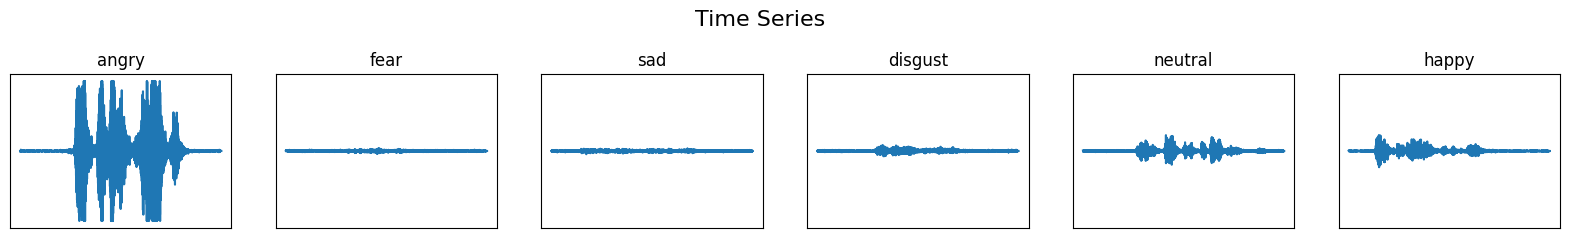

In [14]:
from python_speech_features import mfcc, logfbank

def calc_fft(y,rate):
    n = len(y)
    freq = np.fft.rfftfreq(n, d = 1/rate)
    Y = abs(np.fft.rfft(y)/n)
    return (Y, freq)

classes = list(np.unique(train_df.label))


signals = {}
fft = {}
fbank = {}
mfccs = {}

for c in classes:
    wav_file = train_df[train_df.label == c].iloc[0,0]
    signal, rate = librosa.load(file_dir+'/train/'+wav_file+'.wav', sr=16000)
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft = 1103).T
    mfccs[c] = mel
    
    
plot_signals(signals)
plt.show()


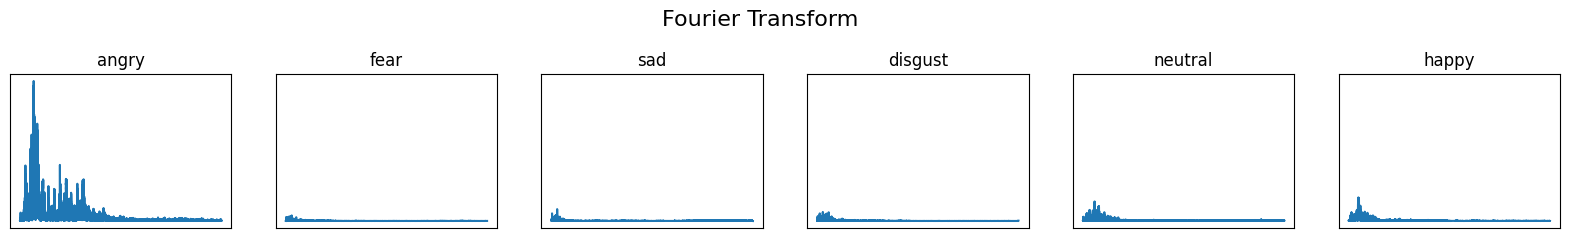

In [15]:
plot_fft(fft)
plt.show()

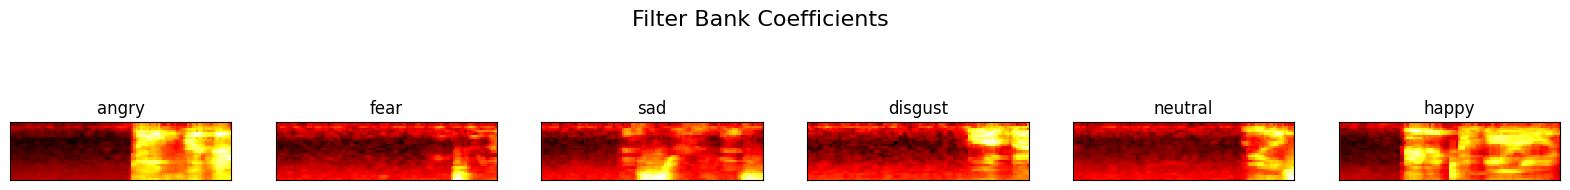

In [16]:
plot_fbank(fbank)
plt.show()

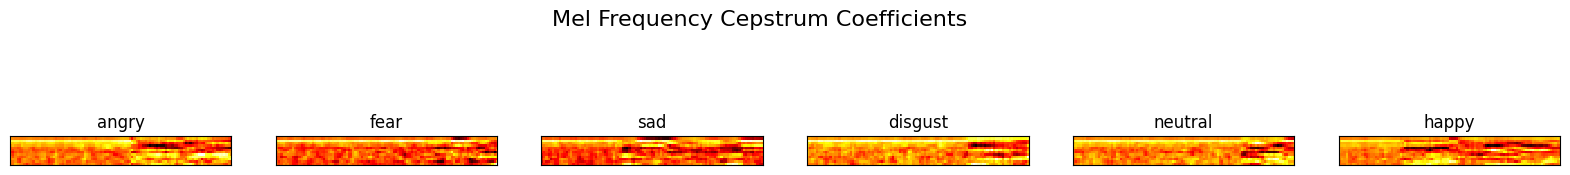

In [17]:
plot_mfccs(mfccs)
plt.show()

In [18]:
def envelope(y, rate, threshold):
    mask = []
    y = pd.Series(y).apply(np.abs)
    y_mean = y.rolling(window = int(rate/10), min_periods = 1, center = True).mean()
    for mean in y_mean:
        if mean > threshold:
            mask.append(True)
        else:
            mask.append(False)
    return mask


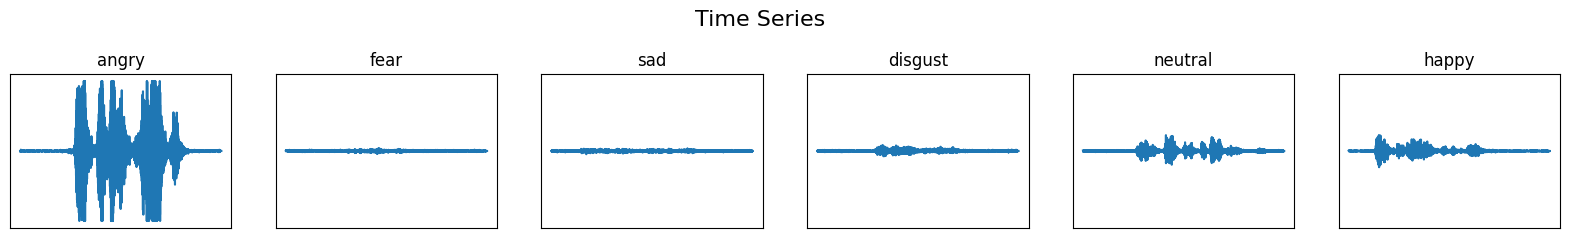

In [19]:
for c in classes:
    wav_file = train_df[train_df.label == c].iloc[0,0]
    signal, rate = librosa.load(file_dir+'/train/'+wav_file+'.wav', sr = 16000)
    mask = envelope(signal, rate, 0.0005)
    signal = signal[mask]
    
    signals[c] = signal
    fft[c] = calc_fft(signal, rate)
    
    bank = logfbank(signal[:rate], rate, nfilt = 26, nfft = 1103).T
    fbank[c] = bank
    mel = mfcc(signal[:rate], rate, numcep = 13, nfilt = 26, nfft = 1103).T
    mfccs[c] = mel
    
    
plot_signals(signals)
plt.show()


In [ ]:
#!unzip -uq "train.zip" -d "데이콘 음성 감정 인식/train" #이렇게 받으면 안에 파일이 풀리니 꼭! 폴더에 지정!

In [ ]:
#!unzip -uq "test.zip" -d "test"

In [20]:
import seaborn as sns
import wave

# 오디오 프레임 수를 반환
train_df['nframes'] = train_df['path'].apply(lambda f: wave.open(f).getnframes())
test_df['nframes'] = test_df['path'].apply(lambda f: wave.open(f).getnframes())


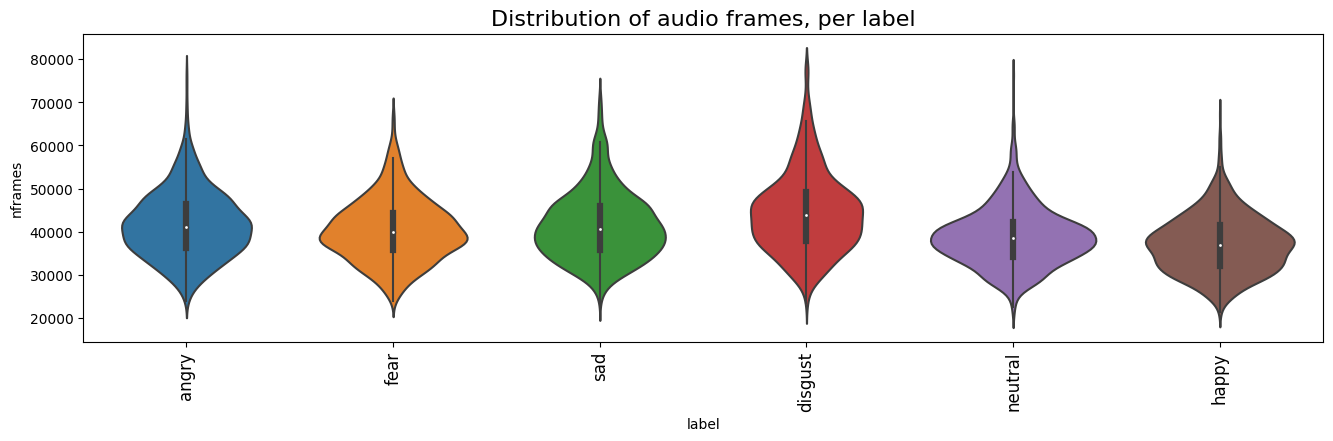

In [21]:
_, ax = plt.subplots(figsize=(16, 4))
sns.violinplot(ax=ax, x="label", y="nframes", data=train_df)
plt.xticks(rotation=90)
ax.set_xticklabels([relabel(i) for i in train_df.label.drop_duplicates().sort_values()], fontsize=12)
plt.title('Distribution of audio frames, per label', fontsize=16)
plt.show()


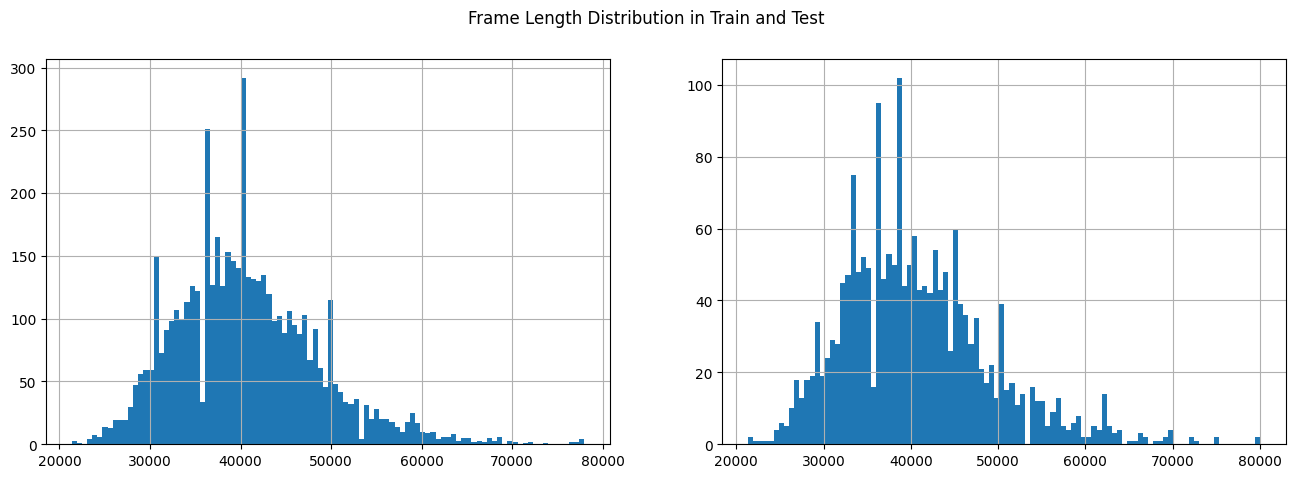

In [22]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(16,5))
train_df.nframes.hist(bins=100, ax=axes[0])
test_df.nframes.hist(bins=100, ax=axes[1])
plt.suptitle('Frame Length Distribution in Train and Test', ha='center', fontsize='large');

In [23]:
import torchaudio

In [24]:
import torch
from tqdm import tqdm
audio_files = []
for i in tqdm(list(train_df.path)):
    i, _ = torchaudio.load(i)
    audio_files.append(i)


100%|█████████████████████████████████████████████████████████████████████████████| 5001/5001 [00:00<00:00, 6605.61it/s]


In [25]:
maxlen = 0
minlen = np.Inf
for i in audio_files:
    if i.shape[1]>maxlen:
        maxlen = i.shape[1]
    if i.shape[1]<minlen:
        minlen = i.shape[1]

In [26]:
minlen, maxlen

(21355, 77945)

In [27]:
#스펙트로그램 변환
spectrograms = []
for i in audio_files:
    specgram = torchaudio.transforms.Spectrogram()(i)
    spectrograms.append(specgram)

In [28]:
max_width, max_height = max([i.shape[2] for i in spectrograms]), max([i.shape[1] for i in spectrograms])

In [29]:
import torch.nn.functional as F

image_batch = [
    # The needed padding is the difference between the
    # max width/height and the image's actual width/height.
    F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])
    for img in spectrograms
]

In [30]:
image_batch[0].shape, image_batch[1].shape, image_batch[2].shape,

(torch.Size([1, 201, 390]),
 torch.Size([1, 201, 390]),
 torch.Size([1, 201, 390]))

In [31]:
image_batch = torch.cat(image_batch,0)

In [32]:
del audio_files, spectrograms

In [34]:
import random

def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)

seed_everything(113) # Seed 고정

In [35]:
from torch.utils.data.dataset import Dataset

class EmotionDataset(Dataset):
    def __init__(self, train_df):
        self.train_df = train_df
        
    def __getitem__(self, index):
        img = list(train_df.path)[index]
        img, _ = torchaudio.load(img)
        img = torch.mean(img, dim=0).unsqueeze(0)
        img = torchaudio.transforms.Spectrogram()(img)
        img = F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])
        
        label = pd.get_dummies(train_df.label).iloc[index]
        label = np.array(label)
        label = torch.from_numpy(label)
        return (img, label)

    def __len__(self):
        count = len(train_df)
        return count

In [71]:
from sklearn.model_selection import train_test_split
X_train, X_test = train_test_split(train_df,test_size=0.3, random_state = 113)

In [40]:
# Reference: https://www.kaggle.com/code/psycheshaman/pytorch-human-speech-classification#Various-classifications-of-speech-data,-via-Deep-Learning-methods,-built-using-PyTorch

In [ ]:
model.eval()

In [209]:
from torch.utils.data import DataLoader

torch.manual_seed(113)
batch_size = 8
train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True, pin_memory=True)
valid_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=False, pin_memory=True)

In [210]:
#!pip install pytorch_lightning

In [211]:
import pytorch_lightning as pl


class MyLearner(pl.LightningModule):

    def __init__(self, model, learning_rate=1e-5):

        super().__init__()
        self.learning_rate = learning_rate
        self.model = model

    def forward(self, x):
        x = self.model(x)
        x = F.log_softmax(x, dim=1)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y.argmax(1))
        return loss

    def validation_step(self, batch, batch_idx, split='val'):
        x, y = batch
        logits = self(x)
        loss = F.nll_loss(logits, y.argmax(1))
        preds = torch.argmax(logits, dim=1)
        #acc = accuracy(preds, y)
        
        total = y.size(0)
        correct = (preds == y.argmax(1)).sum().item()
        acc = correct / total

        self.log(f'{split}_loss', loss, prog_bar=True)
        self.log(f'{split}_acc', acc, prog_bar=True)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return optimizer

    def train_dataloader(self):
        return train_loader

    def val_dataloader(self):
        return valid_loader



In [212]:
import torch
from torch import Tensor
import torch.nn as nn
from typing import Type, Any, Callable, Union, List, Optional

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=dilation, groups=groups, bias=False, dilation=dilation)


def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)


class BasicBlock(nn.Module):
    expansion: int = 1

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(BasicBlock, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        if groups != 1 or base_width != 64:
            raise ValueError('BasicBlock only supports groups=1 and base_width=64')
        if dilation > 1:
            raise NotImplementedError("Dilation > 1 not supported in BasicBlock")
        # Both self.conv1 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = norm_layer(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = norm_layer(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out


class Bottleneck(nn.Module):
    # Bottleneck in torchvision places the stride for downsampling at 3x3 convolution(self.conv2)
    # while original implementation places the stride at the first 1x1 convolution(self.conv1)
    # according to "Deep residual learning for image recognition"https://arxiv.org/abs/1512.03385.
    # This variant is also known as ResNet V1.5 and improves accuracy according to
    # https://ngc.nvidia.com/catalog/model-scripts/nvidia:resnet_50_v1_5_for_pytorch.

    expansion: int = 4

    def __init__(
        self,
        inplanes: int,
        planes: int,
        stride: int = 1,
        downsample: Optional[nn.Module] = None,
        groups: int = 1,
        base_width: int = 64,
        dilation: int = 1,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(Bottleneck, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        width = int(planes * (base_width / 64.)) * groups
        # Both self.conv2 and self.downsample layers downsample the input when stride != 1
        self.conv1 = conv1x1(inplanes, width)
        self.bn1 = norm_layer(width)
        self.conv2 = conv3x3(width, width, stride, groups, dilation)
        self.bn2 = norm_layer(width)
        self.conv3 = conv1x1(width, planes * self.expansion)
        self.bn3 = norm_layer(planes * self.expansion)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x: Tensor) -> Tensor:
        identity = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            identity = self.downsample(x)

        out += identity
        out = self.relu(out)

        return out

In [213]:
# https://pytorch.org/vision/0.9/_modules/torchvision/models/resnet.html
# https://github.com/daisukelab/sound-clf-pytorch/blob/master/src/models.py
class ResNetish(nn.Module):

    def __init__(
        self,
        block: Type[Union[BasicBlock, Bottleneck]],
        layers: List[int],
        num_classes: int = 6,
        zero_init_residual: bool = False,
        groups: int = 1,
        width_per_group: int = 64,
        replace_stride_with_dilation: Optional[List[bool]] = None,
        norm_layer: Optional[Callable[..., nn.Module]] = None
    ) -> None:
        super(ResNetish, self).__init__()
        if norm_layer is None:
            norm_layer = nn.BatchNorm2d
        self._norm_layer = norm_layer

        self.inplanes = 64
        self.dilation = 1
        if replace_stride_with_dilation is None:
            # each element in the tuple indicates if we should replace
            # the 2x2 stride with a dilated convolution instead
            replace_stride_with_dilation = [False, False, False]
        if len(replace_stride_with_dilation) != 3:
            raise ValueError("replace_stride_with_dilation should be None "
                             "or a 3-element tuple, got {}".format(replace_stride_with_dilation))
        self.groups = groups
        self.base_width = width_per_group
        self.conv1 = nn.Conv2d(1, self.inplanes, kernel_size=7, stride=1, padding=3,  # Audio input 3 -> 1, stride 2 -> 1
                               bias=False)
        self.bn1 = norm_layer(self.inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
                                       dilate=replace_stride_with_dilation[0])
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
                                       dilate=replace_stride_with_dilation[1])
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
                                       dilate=replace_stride_with_dilation[2])
        self.avgpool = nn.AdaptiveAvgPool2d((4, 6))
        self.fc = nn.Linear(12288, 6)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, (nn.BatchNorm2d, nn.GroupNorm)):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

        # Zero-initialize the last BN in each residual branch,
        # so that the residual branch starts with zeros, and each residual block behaves like an identity.
        # This improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677
        if zero_init_residual:
            for m in self.modules():
                if isinstance(m, Bottleneck):
                    nn.init.constant_(m.bn3.weight, 0)  # type: ignore[arg-type]
                elif isinstance(m, BasicBlock):
                    nn.init.constant_(m.bn2.weight, 0)  # type: ignore[arg-type]

    def _make_layer(self, block: Type[Union[BasicBlock, Bottleneck]], planes: int, blocks: int,
                    stride: int = 1, dilate: bool = False) -> nn.Sequential:
        norm_layer = self._norm_layer
        downsample = None
        previous_dilation = self.dilation
        if dilate:
            self.dilation *= stride
            stride = 1
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                conv1x1(self.inplanes, planes * block.expansion, stride),
                norm_layer(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample, self.groups,
                            self.base_width, previous_dilation, norm_layer))
        self.inplanes = planes * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups=self.groups,
                                base_width=self.base_width, dilation=self.dilation,
                                norm_layer=norm_layer))

        return nn.Sequential(*layers)

    def _forward_impl(self, x: Tensor) -> Tensor:
        # See note [TorchScript super()]
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

    def forward(self, x: Tensor) -> Tensor:
        return self._forward_impl(x)
    
def _resnet(
    arch: str,
    block: Type[Union[BasicBlock, Bottleneck]],
    layers: List[int],
    **kwargs: Any
) -> ResNetish:
    model = ResNetish(block, layers, **kwargs)
    return model

def resnetish18(num_classes: int, **kwargs: Any) -> ResNetish:
    r"""ResNet-18 model from
    `"Deep Residual Learning for Image Recognition" <https://arxiv.org/pdf/1512.03385.pdf>`_.
    Args:
        pretrained (bool): If True, returns a model pre-trained on ImageNet
        progress (bool): If True, displays a progress bar of the download to stderr
    """
    return _resnet('resnetish18', BasicBlock, [2, 2, 2, 2], num_classes=6,
                   **kwargs)    

In [214]:
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [215]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

torch.set_float32_matmul_precision('high')

learner = MyLearner(resnetish18(6))
# checkpoint로 monitor를 'val_acc'로 했을 때, 디폴트옵션은 mode = 'max'
checkpoint = pl.callbacks.ModelCheckpoint(monitor='val_acc', mode = 'max')
# early_stop 추가로 과적합 방지 
#(acc변화가 사전학습보다 0이상으로 나오지 않으면 1개씩 카운트해서 5개에 도달하면 스탑) 
early_stop_callback = EarlyStopping(
   monitor='val_acc',
   min_delta=0.00,
   patience=5,
   verbose=False,
   mode='max'
)

trainer = pl.Trainer(max_epochs=100, callbacks=[checkpoint, early_stop_callback])
trainer.fit(learner);

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type      | Params
------------------------------------
0 | model | ResNetish | 11.2 M
------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.976    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

In [216]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [217]:
def eval_acc(model, device, dataloader, debug_name=None):
    model = model.to(device).eval()
    count = correct = 0
    for X, gt in dataloader:
        logits = model(X.to(device))
        preds = torch.argmax(logits, dim=1)
        correct += sum(preds.cpu() == gt.argmax(1))
        count += len(gt)
    acc = correct/count
    if debug_name:
        print(f'{debug_name} acc = {acc:.4f}')
    return acc


In [218]:
learner.load_state_dict(torch.load(checkpoint.best_model_path)['state_dict'])
eval_acc(learner.model, device, learner.val_dataloader(), 'val')

val acc = 0.3447


tensor(0.3447)

In [219]:
model = learner.model.to(device).eval()

In [220]:
class EmotionDataset_test(Dataset):
    def __init__(self, test_df):
        self.train_df = test_df
        
    def __getitem__(self, index):
        img = list(test_df.path)[index]
        img, _ = torchaudio.load(img)
        img = torch.mean(img, dim=0).unsqueeze(0)
        img = torchaudio.transforms.Spectrogram()(img)
        img = F.pad(img, [0, max_width - img.size(2), 0, max_height - img.size(1)])
        
        label = pd.get_dummies(test_df.label).iloc[index]
        label = np.array(label)
        label = torch.from_numpy(label)
        return (img, label)

    def __len__(self):
        count = len(test_df)
        return count

In [221]:
test_df['label'] = np.NaN*len(test_df)

In [222]:
test_dt = EmotionDataset_test(test_df)

In [223]:
test_ld = DataLoader(dataset=test_dt, batch_size=batch_size, shuffle=False)

In [224]:
pred = []
outcome = []
labs = []
with torch.no_grad():
    for data, _ in test_ld:
        images = data
        images = images.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        pred.append(predicted)

In [225]:
submission = pd.read_csv(file_dir + '/sample_submission.csv')

In [226]:
submission['label'] = torch.cat(pred).view(-1).cpu().numpy()

<Axes: xlabel='label', ylabel='Count'>

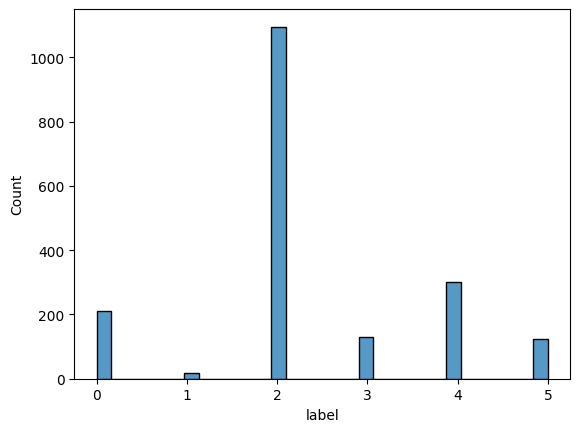

In [227]:
import seaborn as sns
sns.histplot(submission['label'])

In [189]:
submission.to_csv('resnet18_2.csv', index=False,encoding="utf-8-sig")